In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 283 kB 25.1 MB/s 


In [3]:
import numpyro
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
from numpyro.contrib.control_flow import scan


def model(y=None):
    
    # mu = numpyro.sample("mu", numpyro.distributions.Normal(0.0, 10.0))
    # sigma = numpyro.sample("sigma", numpyro.distributions.HalfNormal(10.0))
    mu = numpyro.sample("mu", numpyro.distributions.Normal(3836.1, 10.0))
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfNormal(273827.5))
    
    if y is None:
        numpyro.sample("y", numpyro.distributions.Normal(mu, sigma))
    else:
        with numpyro.handlers.mask(mask=~jnp.isnan(y)):
            numpyro.sample("y", numpyro.distributions.Normal(mu, sigma), obs=y)

3836.0740384615387   273827.4964048447


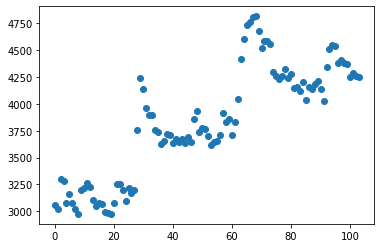

In [79]:
rng_key_ = random.PRNGKey(0)
keys = random.split(rng_key_, 10)


# start
y_book = xlrd.open_workbook('/content/drive/MyDrive/CUICUI/M3C.xls')

# get all four tables(year, quart, month and day) from the xls file
y_years = y_book.sheet_by_index(0)
y_quart = y_book.sheet_by_index(1)
y_month = y_book.sheet_by_index(2)
y_other = y_book.sheet_by_index(3) # day ?

# count of days and columns
day_count = y_other.nrows
day_cols = y_other.ncols

# get first day's data 104
firstline_day = y_other.row_values(1)
day_vals = np.array(firstline_day[6:])
month_vals=np.array((y_month.row_values(1))[6:])

# print(day_vals)
y = day_vals
y_mean = y.mean()
y_var = y.var()
print(y_mean, " ", y_var)

time = [i for i in range(y.shape[0])]
plt.scatter(time, y)
# end

# We generate some synthetic meausurements.
# y = 1.0 + 2.0*random.normal(keys[0], (2000,))

# We set the first 10% of our measurements to nan.
# for idx in range(0, int(0.1*y.shape[0])):
#     y = y.at[idx].set(jnp.nan)

In [6]:
# We are still able to run inference. Our model can handle nan values because of the mask handler.
kernel = numpyro.infer.NUTS(model)
num_samples = 2000
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_, y=y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 499.36it/s, 3 steps of size 9.43e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu   3836.08      9.89   3836.20   3817.87   3850.25   1486.41      1.00
     sigma    528.80     37.11    526.33    469.28    588.02   2128.44      1.00

Number of divergences: 0


**Seasonal, Global Trend (SGT) model**

In [9]:


import os

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)
assert numpyro.__version__.startswith("0.9.2")



In [81]:
month_vals=month_vals[:60]

month_index=np.arange(60)


Length of time series: 60


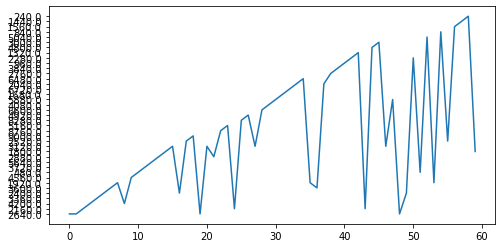

In [82]:
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
#lynx = pd.read_csv(URL, index_col=0)
lynx = month_index
#data = lynx["value"].values
data=month_vals
print("Length of time series:", data.shape[0])
plt.figure(figsize=(8, 4))
plt.plot(month_index, data)
plt.show()

In [68]:
y_train, y_test = jnp.array(data[:40], dtype=jnp.float32), data[40:]

In [83]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

In [84]:
print("Lag values sorted according to their autocorrelation values:\n")
print(jnp.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[ 0  4 37 14 36 35 10  7 31 33 38  3  6  2 16 39 30  5 26 28 34 29  9 22
 19 21 23 12 27 17 25 32 24 11 20  1  8 13 18 15]


In [86]:
%%time
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=14)
mcmc.run(random.PRNGKey(0), y_train, seasonality=14)
mcmc.print_summary()
samples = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: There are not enough devices to run parallel chains: expected 14 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(14)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  
sample: 100%|██████████| 10000/10000 [00:28<00:00, 350.65it/s, 63 steps of size 4.36e-02. acc. prob=0.88]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     37.29    533.80      6.40   -210.99    259.72   1141.79      1.01
       init_s[0]    415.47    947.34    278.29  -1007.20   1868.43  19435.52      1.00
       init_s[1]     31.66    611.99     -0.41   -993.74    964.28  29408.43      1.00
       init_s[2]    -10.53    618.03    -36.43  -1024.58    935.56  30619.50      1.00
       init_s[3]    196.71    767.31    133.83  -1035.01   1381.84  19589.47      1.00
       init_s[4]   1550.42   1260.35   1356.79   -391.71   3452.01  28245.15      1.00
       init_s[5]   -270.51    583.15   -266.37  -1228.87    664.19  40004.49      1.00
       init_s[6]    491.06    779.51    412.45   -754.28   1687.48  25693.97      1.00
       init_s[7]   -330.10    592.04   -300.64  -1331.92    567.42  25197.84      1.00
       init_s[8]   1349.75   1131.58   1196.11   -410.59   2999.65  22854.50      1.00
       init_s[9]    761.08    875.43    67

In [76]:
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=14, future=20)[
    "y_forecast"
]

In [87]:
y_pred = jnp.mean(forecast_marginal, axis=0)
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

TypeError: ignored

ValueError: ignored

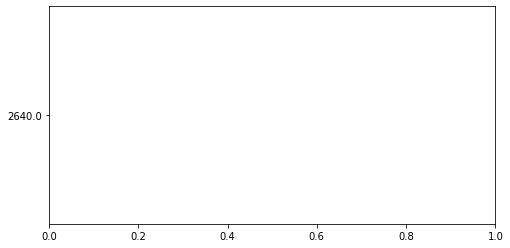

In [58]:
plt.figure(figsize=(8, 4))
#plt.plot(lynx["time"], data)
plt.plot(lynx["time"], data)
t_future = lynx["time"][40:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (90% HPDI)")
plt.show()